In [1]:
 import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
class GamesData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [6]:
def binary_acc(y_pred, y_test):
    correct_results_sum = (torch.round(y_pred) == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [7]:
class SimpleRNN(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(SimpleRNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, inputs):
        x = self.layer_norm(inputs)
        x = self.gelu(x)
        
        x, _ = self.RNN(x)
        x = self.dropout(x)
        
        return x

In [8]:
class BinaryRNN(nn.Module):
    
    def __init__(self, n_rnn_layers, input_size, rnn_dim, dropout=0.5):
        super(BinaryRNN, self).__init__()
        
        self.fc = nn.Linear(input_size, rnn_dim)
        
        self.recursive_layers = nn.Sequential(*[
            SimpleRNN(rnn_dim=rnn_dim, hidden_size=rnn_dim,
                      dropout=dropout, batch_first= i==0)
            for i in range(n_rnn_layers)
        ])
        
        self.fc1 = nn.Linear(rnn_dim, input_size)
        self.batchnorm = nn.BatchNorm1d(input_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.fc(inputs)
        x = self.recursive_layers(x)
        
        x = self.batchnorm(self.fc1(x))
        x = self.gelu(x)
        
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        
        return x

In [9]:
n_epochs = 100
lr = 0.01
models = []

In [10]:
def getDataLoaders(df):
    X = df.drop(columns=['Target'])
    y = df['Target']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.drop(columns=['Date']))
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
    shape = X_train.shape[1]
    
    train_data = GamesData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy()))
    test_data = GamesData(torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy()))
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=True)
    
    return scaler, shape, {'train': train_loader, 'test': test_loader}

In [11]:
def trainModel(model, training_loaders):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    history = {'train': {'Loss': [], 'Accuracy': []}, 'test': {'Loss': [], 'Accuracy': []}}
    for epoch in range(1, n_epochs+1):
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()

            else:
                model.eval()

            epoch_loss = 0
            epoch_acc = 0

            for X_batch, y_batch in training_loaders[phase]:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(X_batch)

                    loss = criterion(y_pred, y_batch.unsqueeze(1))
                    acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_loss += loss.item()
                epoch_acc += acc.item()


            if phase ==  'train':
                exp_lr_scheduler.step()

            hist_loss = epoch_loss/len(training_loaders[phase])
            history[phase]['Loss'].append(hist_loss)
            hist_acc = epoch_acc/len(training_loaders[phase])
            history[phase]['Accuracy'].append(hist_acc)
                        
    return model, history

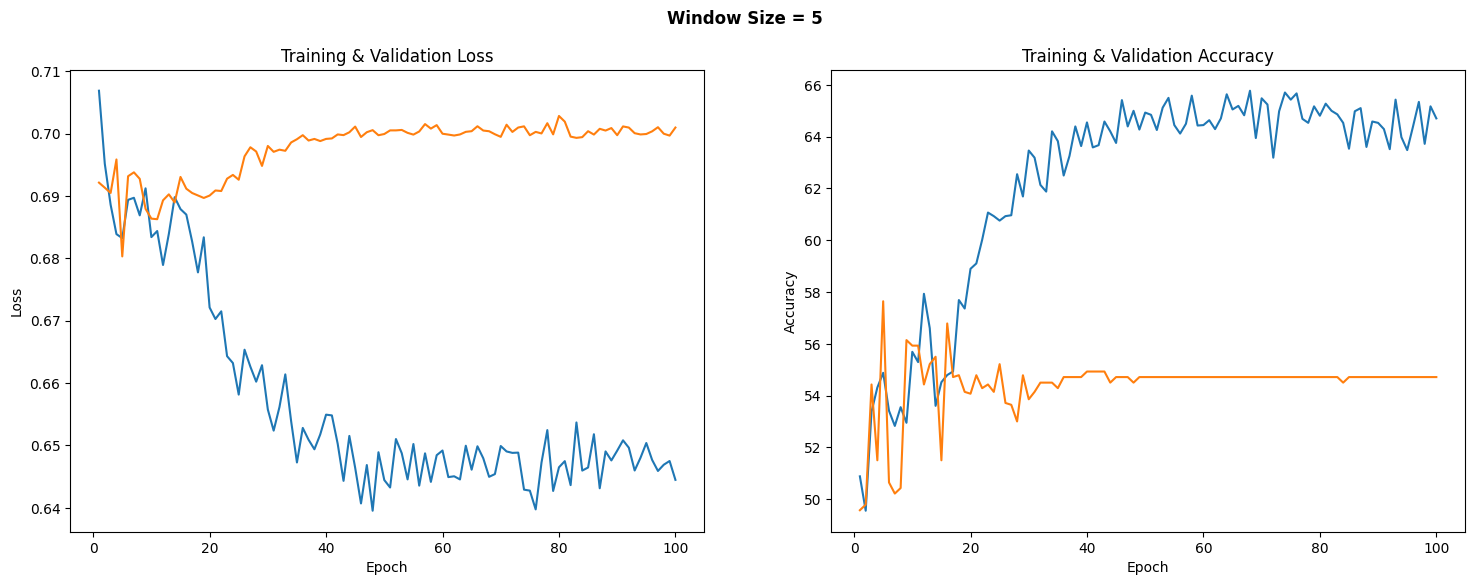

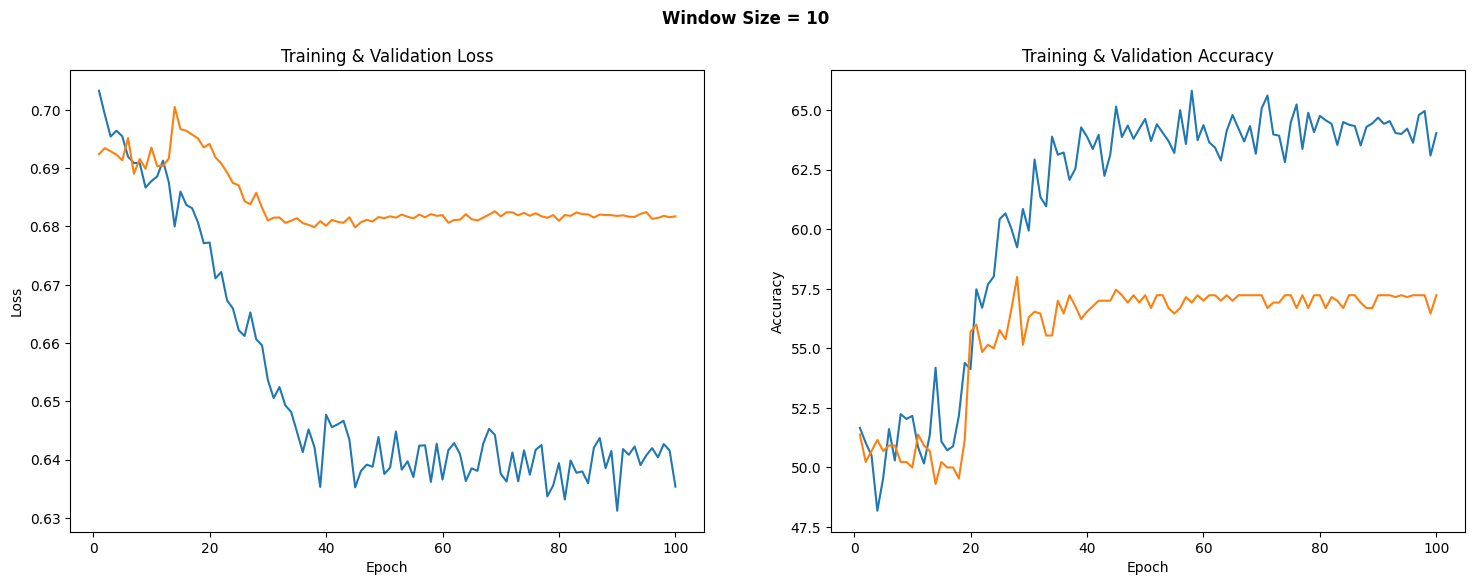

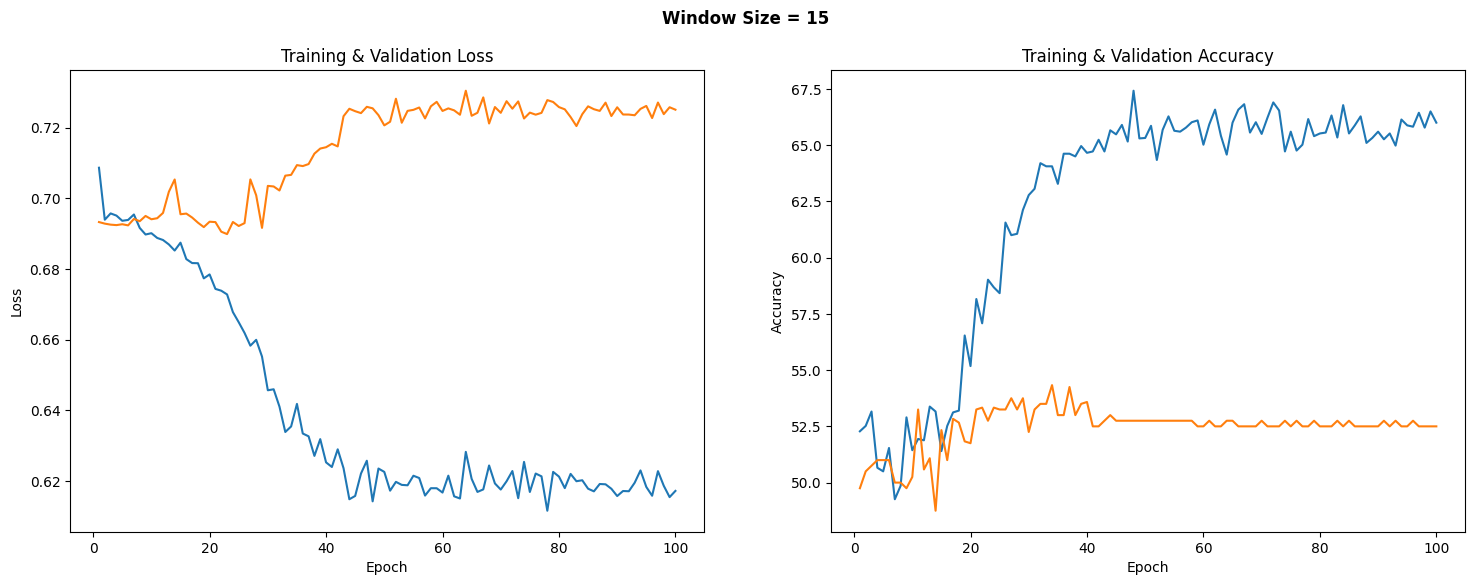

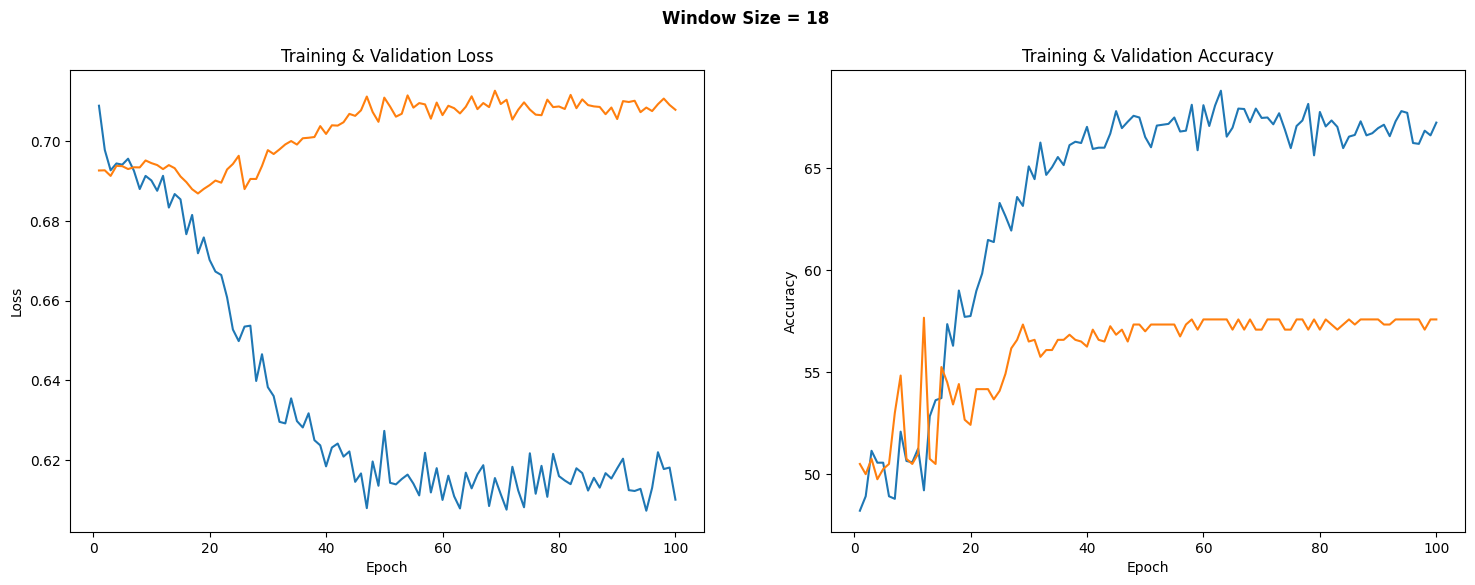

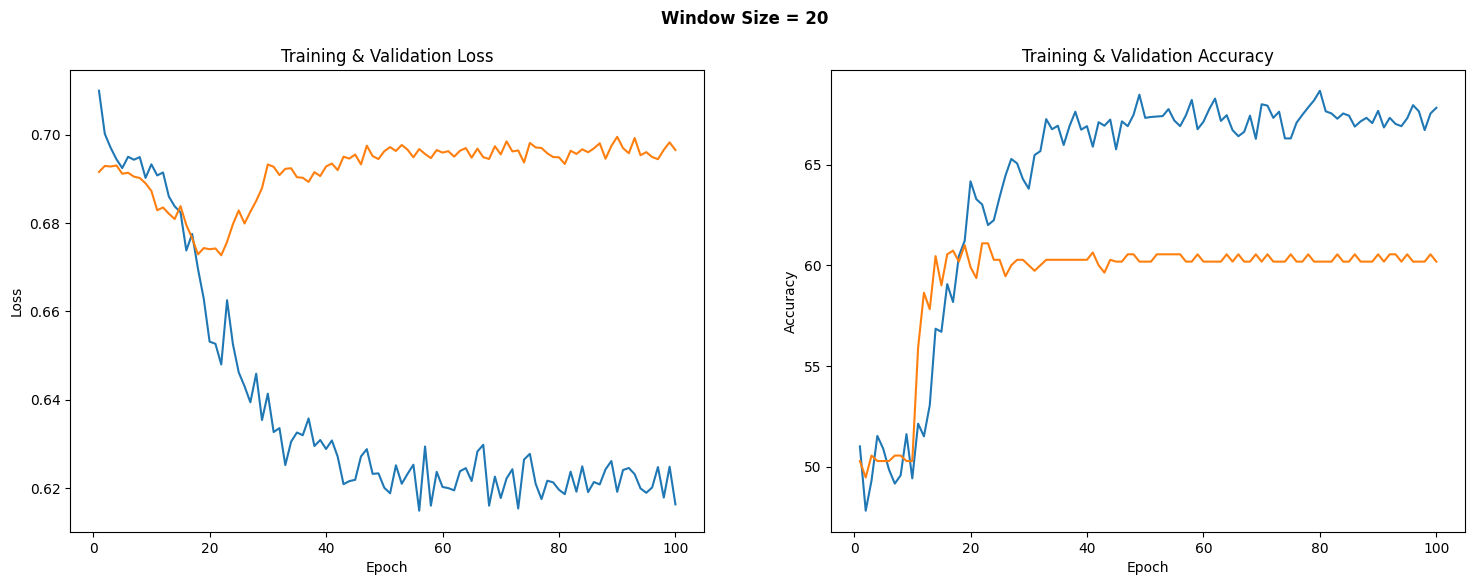

In [12]:
window_sizes = [5,10,15,18,20]
for window in window_sizes:
    window_df = pd.read_excel(f'data/train_{window}.xlsx')

    scaler, shape, training_loaders = getDataLoaders(window_df)
    
    model = BinaryRNN(n_rnn_layers=2, input_size=shape, rnn_dim=256)    
    model, history = trainModel(model, training_loaders)

    acc = history['test']['Accuracy'][-1]
    models.append({'Window': window, 'Model': model, 'Scaler': scaler, 'Accuracy': acc})
            
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))
    axes = axes.flatten()
    
    ax1 = axes[0]
    ax1.plot(range(1, n_epochs+1), history['train']['Loss'])
    ax1.plot(range(1, n_epochs+1), history['test']['Loss'])
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2 = axes[1]
    ax2.plot(range(1, n_epochs+1), history['train']['Accuracy'])
    ax2.plot(range(1, n_epochs+1), history['test']['Accuracy'])
    ax2.set_title('Training & Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    
    fig.suptitle(f'Window Size = {window}', fontweight='bold')
    plt.show()

In [14]:
rnns_df = pd.DataFrame(models).sort_values(by=['Accuracy'], ascending=False).reset_index(drop=True)
rnns_df

,WIndow,Model,Scaler,Accuracy
0,20,"BinaryRNN(\n (fc): Linear(in_features=21, out...",StandardScaler(),60.181818
1,18,"BinaryRNN(\n (fc): Linear(in_features=21, out...",StandardScaler(),57.583333
2,10,"BinaryRNN(\n (fc): Linear(in_features=21, out...",StandardScaler(),57.230769
3,5,"BinaryRNN(\n (fc): Linear(in_features=21, out...",StandardScaler(),54.714286
4,15,"BinaryRNN(\n (fc): Linear(in_features=21, out...",StandardScaler(),52.500000


In [18]:
import joblib

In [19]:
model = rnns_df.iloc[0]['Model']
scaler = rnns_df.iloc[0]['Scaler']

In [21]:
file_model = 'TrainedModels/RNN.pt'
scaler_file = 'Scalers/RNN.pkl'
torch.save(model, file_model)
joblib.dump(scaler, scaler_file, compress=True)

['Scalers/RNN.pkl']